# Who will likely visit your website again in next 30 days?

## Data Science Project - Customer Lifetime Model

<font size="4">***Created by:* Tri Minh Duong**<br>
***Email:* duongtr@sheridancollege.ca**</font>

This project is divided in 4 sections:
1. Business Problem<br>
2. Data Exploration<br>
    2.1 Load and Clean Data<br>
    2.2 Explore the Dataset<br>
    2.3 Calculate Customer Lifetime (CLT) Metrics<br>
3. Model Development<br>
    3.1 Build Train and Test Dataset<br>
    3.2 Train the Model<br>
    3.3 Evaluate the Model<br>
    3.4 Calculate other Features<br>
-------------------------------------

# 1. Business Problem

As an online retailer with a non-subscription business model, our customers can come and go without long-term commitments. This creates challenge for the business to determine whether a customer will return in the future. Being able to indentify who are our loyal customers and the probability that they are coming back in a specific period of time in future helps the marketing team maximize the outcomes for their marketing campaigns. It also helps the company proactively incentivize customers who have likely dropped out to return to our website.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd

import lifetimes as lt
from lifetimes import plotting as ltplt
from lifetimes import ParetoNBDFitter, BetaGeoFitter
from hyperopt import hp, fmin, STATUS_OK, STATUS_FAIL, Trials, space_eval, tpe

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from datetime import timedelta

import pandasql as ps

%matplotlib inline

# 2. Data Exploration

## 2.1 Load and Clean Data

The dataset we will use is the Online Retail Data Set available from the UCI Machine Learning Repository.

In [2]:
# Loading data to data frame
orders = pd.read_excel('Online Retail.xlsx',
                       sheet_name='Online Retail',
                       header=0)
orders.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# Assessing dataset
orders.info()
print()
print(orders.isnull().any())
print()
print('Invoice Date is from', orders.InvoiceDate.min(), ' to', orders.InvoiceDate.max())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB

InvoiceNo      False
StockCode      False
Description     True
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID      True
Country        False
dtype: bool

Invoice Date is from 2010-12-01 08:26:00  to 2011-12-09 12:50:00


This data set includes invoices from December 1, 2010 to December 9, 2011. There are 541,909 records of sales during this time. However, some of them have missing values in CustomerID field. This field is identifical for this project as it helps us to identify which customers the transactions belong to.

Another field which has missing values is 'Description'. This field is not needed for this model as this project will not consider specific product categories. In reality, we can easily gather information of this field from product reference data based on StockCode.

In [4]:
# Removing all records with no value on CustomerID field
orders = orders[orders['CustomerID'].notna()]
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      406829 non-null object
StockCode      406829 non-null object
Description    406829 non-null object
Quantity       406829 non-null int64
InvoiceDate    406829 non-null datetime64[ns]
UnitPrice      406829 non-null float64
CustomerID     406829 non-null float64
Country        406829 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [5]:
# Converting data type on 'CustomerID' from float to string
orders['CustomerID'] = orders['CustomerID'].astype(int).astype(str)
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      406829 non-null object
StockCode      406829 non-null object
Description    406829 non-null object
Quantity       406829 non-null int64
InvoiceDate    406829 non-null datetime64[ns]
UnitPrice      406829 non-null float64
CustomerID     406829 non-null object
Country        406829 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.9+ MB


In [6]:
orders.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [7]:
# Assessing if there are duplicates in the dataset
print("Number of duplicated records in dataset:", orders.duplicated().sum())

Number of duplicated records in dataset: 5225


There are 5225 duplicated records. In this case, there will not be any affects in manipulating **Frequency (number of transactions in days)** and **Recency (how long the customer is with the company at the last purchase day)** for each customer for the lifetime model as these values are calculated in "Day". However, they will affect the **average purchase values** when we are estimating customer lifetime monetary values. In retail business and depend on company system, customers might allow to make same purchases with same quantities in the same purchase orders.

In the scope for this project, we can ignore this issue.

In [8]:
# Extracting descriptive statistics on each numerical variable
orders.describe()

,Quantity,UnitPrice
count,406829.000000,406829.000000
mean,12.061303,3.460471
std,248.693370,69.315162
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


The minimum value in 'Quantity' field is negative. It means that the dataset also include the records of customer returning the purchased items. We are going to looking into this field more to confirm the number of records with negative quantity. Additionally, the maximum value is quite high and it is the positive value of the minimum quantity. It might ring the bell that these 2 values were from same customer.

In [9]:
# Counting number of records with negative quantity
print('Number of records with negative quantity:', orders[orders['Quantity'] <= 0].CustomerID.count())

Number of records with negative quantity: 8905


There are 8905 records of customers returning purchase items. This will depend on business decisions whether:
1. To exclude the records with 0 or negative quantity
2. To include all records

In this project, we will exclude the records with 0 or negative quantity for the model development. If the last transactions from customers are for returning, they should not be consider as actual transactions as they caused the company to lose profit (refund plus shipping cost if the business promised to cover that)

In [10]:
# Showing the records with quantity of +/-80995
orders[(orders['Quantity'] == -80995) | (orders['Quantity'] == 80995)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446,United Kingdom


Since we are calculating the customer's frequency by 'Day' and we exclude the records with negative quantity from the dataset, we can skip this problem.

In [11]:
# Removing records with 0 or negative quantity from dataset
orders_cleandata = orders[orders['Quantity'] > 0]
orders_cleandata[['Quantity', 'UnitPrice']].describe()

,Quantity,UnitPrice
count,397924.000000,397924.000000
mean,13.021823,3.116174
std,180.420210,22.096788
min,1.000000,0.000000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


Now we will be looking into the second numeric feature 'UnitPrice'. The minimum value here is 0 which is not usual. We will see what those records are.

In [12]:
orders_cleandata[orders_cleandata['UnitPrice'] == 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647,Germany
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560,United Kingdom
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911,EIRE
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081,United Kingdom
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081,United Kingdom
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,2011-01-13 15:10:00,0.0,15107,United Kingdom
86789,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2011-02-10 13:08:00,0.0,17560,United Kingdom
130188,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,2011-03-23 10:25:00,0.0,13239,United Kingdom
139453,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,2011-03-30 12:45:00,0.0,13113,United Kingdom
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,2011-04-04 14:42:00,0.0,14410,United Kingdom


These transactions did not bring any revenues to the company. Normally, we should discuss with business stakeholder for decisions whether they should be included in the calculation. Their stock descriptions show us that some purchase items might be the free services that come along with other items.

For the scope of this project, we will not consider these records as transactions.

In [13]:
orders_cleandata = orders_cleandata[orders_cleandata['UnitPrice'] > 0]

In [14]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      406829 non-null object
StockCode      406829 non-null object
Description    406829 non-null object
Quantity       406829 non-null int64
InvoiceDate    406829 non-null datetime64[ns]
UnitPrice      406829 non-null float64
CustomerID     406829 non-null object
Country        406829 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.9+ MB


In [15]:
orders_cleandata.describe()

,Quantity,UnitPrice
count,397884.000000,397884.000000
mean,12.988238,3.116488
std,179.331775,22.097877
min,1.000000,0.001000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


## 2.2 Explore the Dataset

In [16]:
# Reviewing the dataset after cleaning
print('The dataset includes invoices from', orders_cleandata.InvoiceDate.min(), ' to', orders_cleandata.InvoiceDate.max())

The dataset includes invoices from 2010-12-01 08:26:00  to 2011-12-09 12:50:00


In [17]:
# Counting number of customers and distinct InvoiceNo
print("Number of customers:", orders_cleandata.CustomerID.nunique())
print("Number of invoices:", orders_cleandata.InvoiceNo.nunique())

Number of customers: 4338
Number of invoices: 18532


For the little more than 1-year period, we had more than 4338 customers making 18532 purchase orders with the business.

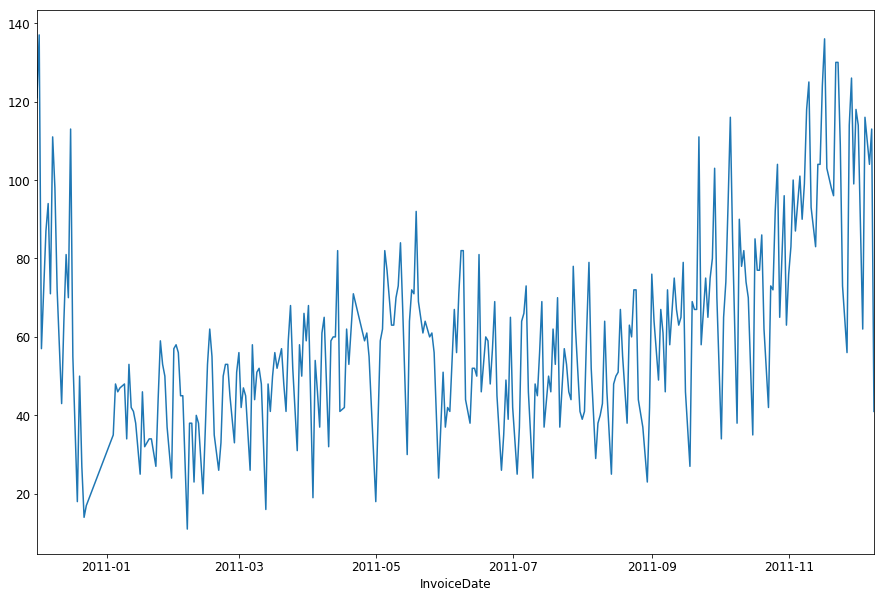

In [18]:
# Plotting number of distinct InvoiceNo per each InvoiceDate
plt.figure(figsize=(15, 10))
plt.rcParams["font.size"] = 12
orders_cleandata.groupby(orders_cleandata['InvoiceDate'].dt.date)['InvoiceNo'].nunique().plot.line()

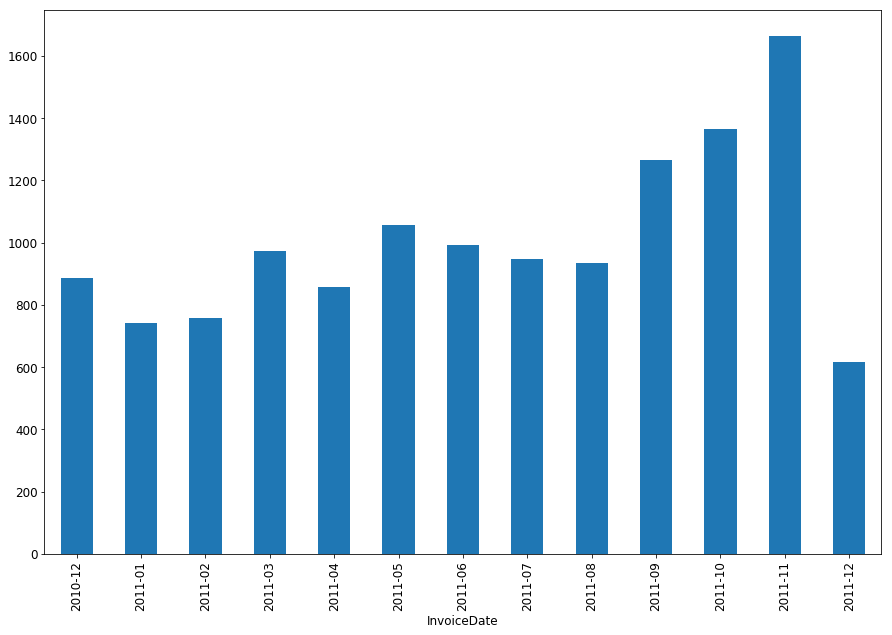

In [19]:
# Counting number of distinct customers by month
plt.figure(figsize=(15, 10))
orders_cleandata.groupby(orders_cleandata['InvoiceDate'].dt.to_period("M"))['CustomerID'].nunique().plot(kind='bar')

Text(0, 0.5, 'Frequency')

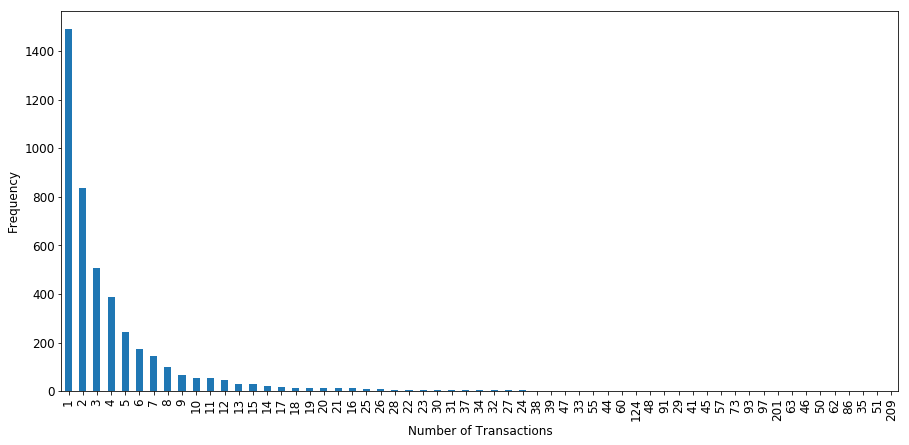

In [20]:
# Counting number of unique InvoiceNo for each customer
pvt = orders_cleandata.pivot_table(values='InvoiceNo', index='CustomerID', aggfunc=pd.Series.nunique)

# Plotting the frequency of each value of number of unique InvoiceNo
plt.figure(figsize=(15,7))
plt.rcParams["font.size"]=12
pvt['InvoiceNo'].value_counts().plot(kind='bar')
plt.xlabel('Number of Transactions')
plt.ylabel('Frequency')

By counting the number of unique transactions (InvoiceNo) on each customer, we can see that most of them only had 1 transaction during that 1 year. The distribution of the count of repeat purchases declines in a manner that we could describe as **Negative Binomial Distribution (NBD)**.

We will use the same analysis but we are counting the number of unique transaction dates (InvoiceDate) on each customer.

In [21]:
orders_cleandata['temp'] = orders_cleandata['InvoiceDate'].dt.date
orders_cleandata.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,temp
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01


Text(0, 0.5, 'Frequency')

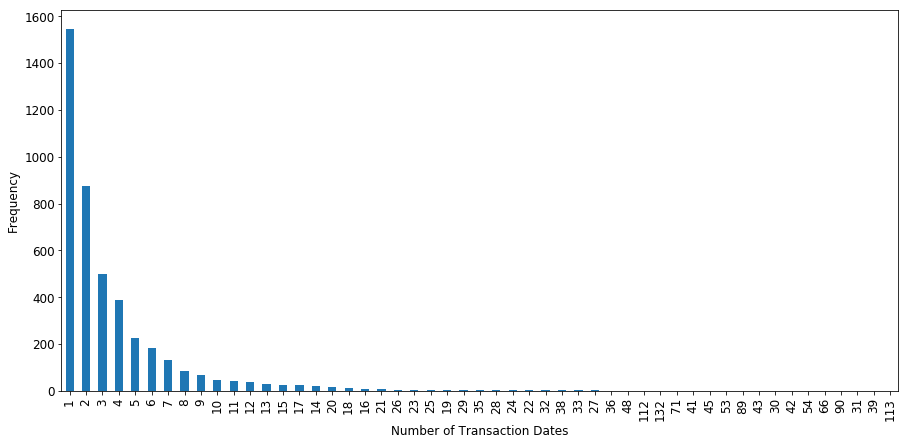

In [22]:
# Counting number of unique InvoiceDate for each customer
pvt = orders_cleandata.pivot_table(values='temp', index='CustomerID', aggfunc=pd.Series.nunique)

# Plotting the frequency of each number of unique InvoiceDate 
plt.figure(figsize=(15,7))
plt.rcParams["font.size"] = 12
pvt['temp'].value_counts().plot(kind='bar')
plt.xlabel('Number of Transaction Dates')
plt.ylabel('Frequency')

The distribution is also considered as Negative Binomial Distribution (NBD) same as previous chart. The difference is that the maximum number of transaction dates is 113 instead of 209 in previous chart.

In [23]:
# Removing the temporary column
orders_cleandata.drop(['temp'], axis=1, inplace=True)
orders_cleandata.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


We are going to assess the customers with repeat purchases to see how long on average each customer made another purchase on our website.

In [24]:
sql = """
    WITH Customer_TransactionDates AS
        (
            SELECT DISTINCT CustomerID, strftime('%Y-%m-%d', InvoiceDate) AS InvoiceDate
            FROM orders_cleandata
        )
    SELECT CustomerID, AVG(julianday(NextInvoiceDate)-julianday(InvoiceDate)) AS AverageDays
    FROM (
            SELECT t1.CustomerID, t1.InvoiceDate, MIN(t2.InvoiceDate) AS NextInvoiceDate
            FROM Customer_TransactionDates t1
            INNER JOIN Customer_TransactionDates t2
            ON t1.CustomerID = t2.CustomerID AND t1.InvoiceDate < t2.InvoiceDate
            GROUP BY t1.CustomerID, t1.InvoiceDate
        )
    GROUP BY CustomerID;
"""

sql_results = ps.sqldf(sql)
sql_results.head()

,CustomerID,AverageDays
0,12347,60.833333
1,12348,94.333333
2,12352,43.333333
3,12356,151.500000
4,12358,149.000000


<Figure size 1440x720 with 0 Axes>

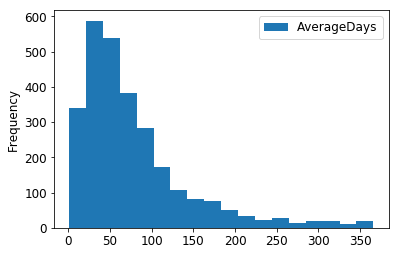

In [25]:
# Ploting the average days between transactions on each customer to histogram
plt.figure(figsize=(20,10))
plt.rcParams["font.size"] = 12
sql_results.plot.hist(bins=18);

We can see that most customers returned to the site within 2 to 3 months of a prior purchase. There are very few customers having longer gap between their purchases. The time since we last saw a customer could affect the determination of whether a customer would likely come back to the website.

## 2.3 Calculate Customer Lifetime (CLT) Metrics

In order to build a customer lifetime value model, we need to generate some addtional metrics for each customer:
- Frequency: the number of dates on which a customer made purchases after the customer's first purchase.
- Age (T): the number of days from the customer's first purchase date to the current date (last InvoiceDate in the dataset)
- Recency: the number of days from the customer's first purchase date to the date that customer made the last purchase.

In [26]:
# Setting the last InvoiceDate in the dataset as the current date
current_date = orders_cleandata['InvoiceDate'].max()

# Generating metrics for each customer
customer_metrics = lt.utils.summary_data_from_transaction_data(orders_cleandata,
                                                              customer_id_col='CustomerID',
                                                              datetime_col='InvoiceDate',
                                                              observation_period_end=current_date,
                                                              freq='D')

customer_metrics.head()

,frequency,recency,T
CustomerID,,,
12346,0.0,0.0,325.0
12347,6.0,365.0,367.0
12348,3.0,283.0,358.0
12349,0.0,0.0,18.0
12350,0.0,0.0,310.0


In [27]:
# Showing descriptive statistics on each variable in customer_metrics dataset
customer_metrics.describe()

,frequency,recency,T
count,4338.000000,4338.000000,4338.000000
mean,2.864223,130.771554,222.831028
std,5.949000,132.210509,117.854570
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,112.000000
50%,1.000000,93.000000,248.000000
75%,3.000000,252.000000,326.000000
max,131.000000,373.000000,373.000000


# 3. Model Development

## 3.1 Build Train and Test Dataset

With CLT model, we will train model on an earlier portion of the time series (*calibration period*) and validate against a later portion of the time series (*holdout period*).

In this dataset, we are using the last 90-days of data as the holdout period.

In [28]:
# Defining end of calibration period
holdout_period = 90
calibration_period_end_date = current_date - timedelta(days=holdout_period)

# Calculating the customer metrics during calibration period
metrics_cal = lt.utils.calibration_and_holdout_data(orders_cleandata,
                                                   customer_id_col='CustomerID',
                                                   datetime_col='InvoiceDate',
                                                   observation_period_end=current_date,
                                                   calibration_period_end=calibration_period_end_date,
                                                   freq='D')

metrics_cal.head(10)

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346,0.0,0.0,235.0,0.0,90.0
12347,4.0,238.0,277.0,2.0,90.0
12348,2.0,110.0,268.0,1.0,90.0
12350,0.0,0.0,220.0,0.0,90.0
12352,3.0,34.0,206.0,3.0,90.0
12353,0.0,0.0,114.0,0.0,90.0
12354,0.0,0.0,142.0,0.0,90.0
12355,0.0,0.0,124.0,0.0,90.0
12356,1.0,80.0,235.0,1.0,90.0


In [29]:
# Showing descriptive statistics on each variable in dataset
metrics_cal.describe()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
count,3370.000000,3370.000000,3370.000000,3370.000000,3370.0
mean,2.206825,87.905045,182.903264,1.329970,90.0
std,4.626791,95.479894,80.455546,2.261153,0.0
min,0.000000,0.000000,1.000000,0.000000,90.0
25%,0.000000,0.000000,123.000000,0.000000,90.0
50%,1.000000,55.000000,193.000000,1.000000,90.0
75%,3.000000,170.000000,265.000000,2.000000,90.0
max,82.000000,282.000000,283.000000,49.000000,90.0


We are using Pareto/NBD and BG/NBD models for the model training. These two models can only perform manipulations on customers with repeat transactions (Frequency > 0). Therefore, we will exclude the customers with frequency_cal as 0.

In [30]:
# Filtering the customers with frequency_cal > 0
metrics_filtered_cal = metrics_cal[metrics_cal['frequency_cal']>0]
metrics_filtered_cal.describe()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
count,1956.000000,1956.000000,1956.000000,1956.000000,1956.0
mean,3.802147,151.451943,211.171779,1.870654,90.0
std,5.551730,77.979775,65.793991,2.729424,0.0
min,1.000000,1.000000,3.000000,0.000000,90.0
25%,1.000000,89.000000,169.000000,0.000000,90.0
50%,2.000000,154.000000,226.000000,1.000000,90.0
75%,4.000000,218.250000,272.000000,2.000000,90.0
max,82.000000,282.000000,283.000000,49.000000,90.0


## 3.2 Train the Model

Firstly, we will train the model using Pareto/NBD algorithm with basic simple parameter to get the baseline.

In [31]:
# fitting a model with ParetoNBDFitter
model = ParetoNBDFitter(penalizer_coef=0.0)
model.fit(metrics_filtered_cal['frequency_cal'], metrics_filtered_cal['recency_cal'], metrics_filtered_cal['T_cal'])
print(model.params_)

r        2.041335e+00
alpha    1.160231e+02
s        3.889850e-11
beta     3.347182e+02
dtype: float64


In the Customer Lifetime model, we could use MSE, RMSE or MAE to evaluate the model performance. By default, we will use MSE in this project.

In [32]:
# Creating function to manipulate evaluation metrics

def model_score(actual, predicted, score='mse'):
    # Converting the metric name to lower case
    score = score.lower()
    
    if (score=='mse'):
        val = np.sum(np.square(actual - predicted))/actual.shape[0]
    elif (score=='rmse'):
        val = np.sqrt(np.sum(np.square(actual - predicted))/actual.shape[0])
    elif (score=='mae'):
        val = np.sum(np.abs(actual - predicted))/actual.shape[0]
    else:
        val = None
        
    return val

In [33]:
# Getting predicted frequency during holdout period
frequency_predicted = model.predict(metrics_filtered_cal['duration_holdout'],
                                   metrics_filtered_cal['frequency_cal'],
                                   metrics_filtered_cal['recency_cal'],
                                   metrics_filtered_cal['T_cal'])

frequency_actual = metrics_filtered_cal['frequency_holdout']

# Getting evaluation score in MSE
mse = model_score(frequency_actual, frequency_predicted)

print('MSE score is', mse)

MSE score is 3.558581745797393


In this project, we will train the model using **Pareto/NBD model** and **BG/NBD model**. They have the same constrain in terms of data (exclude the customers with the frequency_cal value less than 0). We will implement hyperparameter tuning with library *hyperopt* for *penalizer_coef* between 0 and 1 to find the best algorithm with the best value on penalizer_coef.

In [34]:
# Defining search space
search_space = hp.choice('model_type',
                        [{'type':'Pareto/NBD', 'l2':hp.uniform('pareto_nbd', 0, 1)},
                        {'type':'BG/NBD', 'l2':hp.uniform('bg_nbd', 0, 1)}])

# Defining loss function for model evaluation
def model_evaluation(params):
    data = metrics_filtered_cal
    
    # Retrieve parameters
    model_type = params['type']
    l2 = params['l2']
    
    # Initiate model
    if (model_type == 'Pareto/NBD'):
        model = ParetoNBDFitter(penalizer_coef=l2)
    elif (model_type == 'BG/NBD'):
        model = BetaGeoFitter(penalizer_coef=l2)
    else:
        return {'loss':None, 'status':STATUS_FAIL}
    
    # Fit the model
    model.fit(data['frequency_cal'], data['recency_cal'], data['T_cal'])
    
    # Evaluate the model
    predictions = model.predict(data['duration_holdout'], data['frequency_cal'], data['recency_cal'], data['T_cal'])
    actuals = data['frequency_holdout']
    score = model_score(actuals, predictions, 'mse')
    
    return {'loss':score, 'status':STATUS_OK}

In [35]:
# Hyper-parameter tuning
best_model = fmin(fn=model_evaluation,
                 space=search_space,
                 algo = tpe.suggest,
                 max_evals=300,
                 trials=Trials())

# Print results with best model and penalizer_coef
print(space_eval(search_space, best_model))

100%|██████████| 300/300 [01:06<00:00,  6.58trial/s, best loss: 2.975497991183963]
{'l2': 0.9999572732461548, 'type': 'BG/NBD'}


The searching is able to provide us with best model type and best penalizer_coef value. We will train the model with these paramters.

In [36]:
best_params = space_eval(search_space, best_model)

model_type = best_params['type']
l2 = best_params['l2']

if (model_type == 'Pareto/NBD'):
    model = ParetoNBDFitter(penalizer_coef=l2)
elif (model_type == 'BG/NBD'):
    model = BetaGeoFitter(penalizer_coef=l2)
else:
    raise 'Unrecognized model type'
    
model.fit(metrics_filtered_cal['frequency_cal'], metrics_filtered_cal['recency_cal'], metrics_filtered_cal['T_cal'])

print(model.params_)

r         0.452732
alpha    23.815613
a         0.000557
b         0.012788
dtype: float64


## 3.3 Evaluate the Model

In [37]:
# Getting predicted frequency during holdout period
predictions = model.predict(metrics_filtered_cal['duration_holdout'],
                                   metrics_filtered_cal['frequency_cal'],
                                   metrics_filtered_cal['recency_cal'],
                                   metrics_filtered_cal['T_cal'])

actuals = metrics_filtered_cal['frequency_holdout']

# Getting evaluation score in MSE
MSE = model_score(actuals, predictions, 'mse')

print('MSE score is', mse)

MSE score is 3.558581745797393


The MSE score is ----. Now, we are comparing the predicted frequencies and actual frequencies in the holdout period given by the frequencies in calibration period to see how close our predicted values with the actual values.

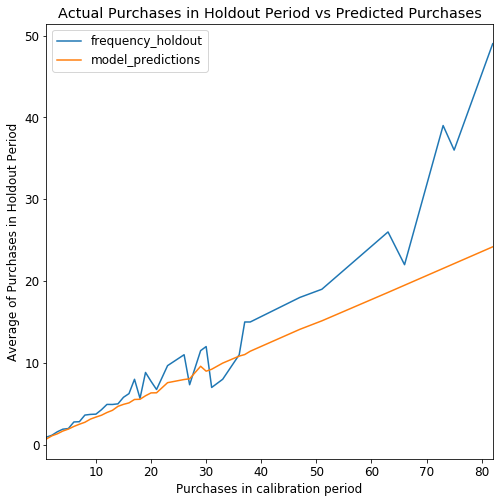

In [38]:
ltplt.plot_calibration_purchases_vs_holdout_purchases(model, metrics_filtered_cal, n=90, **{'figsize':(8,8)});

The chart shows us that the higher number of purchases in calibration period predicted the higher number of purchases in holdout period. The variance between the actual and predicted number of purchases is closer when the number of purchases in calibration period is less than 40. When the customers have more than 40 purchases in calibration period, the more purchases they made in calibration period, the higher the variance between actual and predicted values in holdout period is. However, since the predicted values are always less than the actual values, we can say that this will not cause the negative affect on business forecast.

Now, we will look into the relationship between the time customers made the last purchases in calibration period and the number of purchases in holdout period.

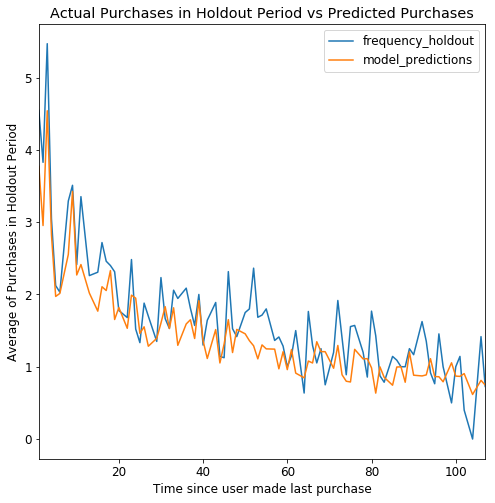

In [39]:
ltplt.plot_calibration_purchases_vs_holdout_purchases(model, 
                                                      metrics_filtered_cal, 
                                                      kind="time_since_last_purchase", 
                                                      n=90, 
                                                     **{'figsize':(8,8)});

The chart illustrated that as the time since the customer made last purchase increases, the number of purchases in holdout period decreases. We see that both predicted values and actual values are moving in the same direction and the preditions are usually less than the actual values. This helps the business avoid overestimating the number of purchases from their customers.

Next, we are looking into the customers' recency during calibration period (age of the customers when they made the last purchases) to see if these values influence the customers' frequency in holdout period.

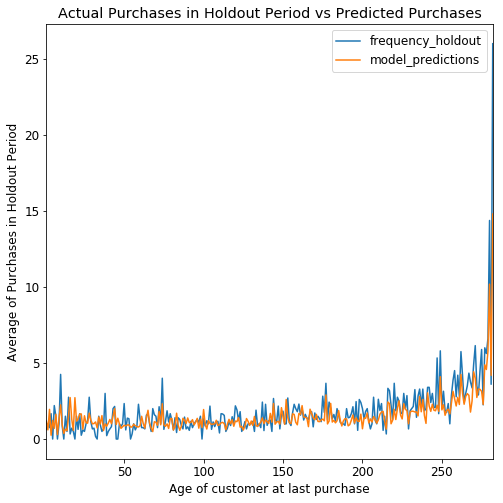

In [40]:
ltplt.plot_calibration_purchases_vs_holdout_purchases(model, 
                                                     metrics_filtered_cal,
                                                     kind="recency_cal",
                                                     n=300,
                                                     **{'figsize':(8,8)});

We can see that there is no strong relationships between age of customer at last purchase and the number of purchases in holdout period.

## 3.4 Calculate other Features

With this customer lifetime model, we can calculate the probability a customer remains in our business as of the current calibration end date.

In [41]:
# Calculate the probability a customer is currently alive
metrics_filtered = customer_metrics[customer_metrics['frequency'] > 0]
metrics_filtered['prob_alive'] = model.conditional_probability_alive(metrics_filtered['frequency'],
                                                                         metrics_filtered['recency'],
                                                                         metrics_filtered['T'])
metrics_filtered.head()

,frequency,recency,T,prob_alive
CustomerID,,,,
12347,6.0,365.0,367.0,0.999885
12348,3.0,283.0,358.0,0.999412
12352,6.0,260.0,296.0,0.999760
12356,2.0,303.0,325.0,0.999355
12358,1.0,149.0,150.0,0.957931


Being able to get the probability a customer is current alive with the business is very helpful in executing marketing campaigns. The marketing team can segment the list of customers and decide how much budget they want to spend on their strategies.

Let's take a look at how the probability a customer is alive (continue purchasing from the store) is changed based on the historical purchases.

<Figure size 432x288 with 0 Axes>

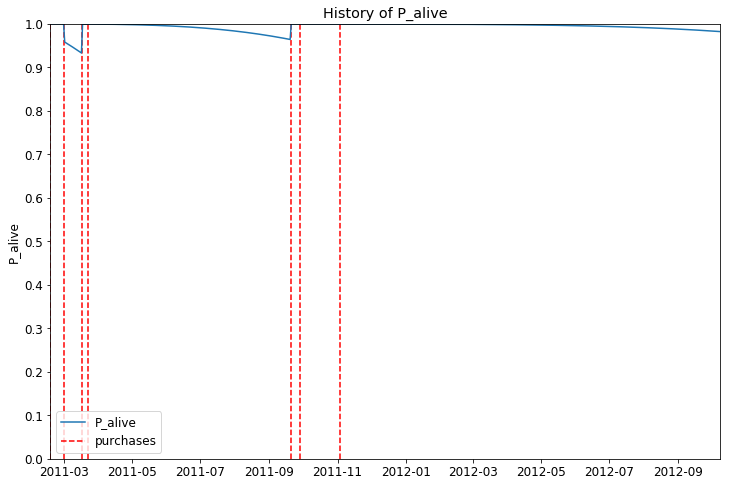

In [42]:
plt.clf()

# Customer of interest
customerid = '12352'

# Query customer's historical transactions
transactions = orders_cleandata[orders_cleandata['CustomerID']==customerid]

# Calculate the number of days in this dataset
delta = orders['InvoiceDate'].max() - orders['InvoiceDate'].min()

plt.figure(figsize=(12,8))
# Plotting history of being 'alive'
ltplt.plot_history_alive(model,
                        600,
                        transactions,
                        'InvoiceDate');

In [43]:
transactions.sort_values(by=['InvoiceDate']).head(20)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
91817,544156,21380,WOODEN HAPPY BIRTHDAY GARLAND,6,2011-02-16 12:33:00,2.95,12352,Norway
91831,544156,22780,LIGHT GARLAND BUTTERFILES PINK,4,2011-02-16 12:33:00,4.25,12352,Norway
91830,544156,22630,DOLLY GIRL LUNCH BOX,12,2011-02-16 12:33:00,1.95,12352,Norway
91828,544156,22853,CAT BOWL VINTAGE CREAM,6,2011-02-16 12:33:00,3.25,12352,Norway
91827,544156,21754,HOME BUILDING BLOCK WORD,3,2011-02-16 12:33:00,5.95,12352,Norway
91826,544156,21756,BATH BUILDING BLOCK WORD,3,2011-02-16 12:33:00,5.95,12352,Norway
91825,544156,21755,LOVE BUILDING BLOCK WORD,3,2011-02-16 12:33:00,5.95,12352,Norway
91829,544156,21700,BIG DOUGHNUT FRIDGE MAGNETS,12,2011-02-16 12:33:00,0.85,12352,Norway
91823,544156,22654,DELUXE SEWING KIT,3,2011-02-16 12:33:00,5.95,12352,Norway
91822,544156,22423,REGENCY CAKESTAND 3 TIER,3,2011-02-16 12:33:00,12.75,12352,Norway


The customer with the ID as 12352 made his/her first repeated purchase on March 1, 2011 after his first purchase. The customer made other 2 transactions during that month. He/She did not make any purchases between April and mid of September. The probability of customer being alive declined. However, he/she made 2 transactions at the end of September and the probability of customer being alive reset to 1. The last purchase was made around begining of October 2011. AS of now (January 2012), the probability of the customer being alive is still around 1. It wil decrease slowly especially from June 2012.

Now, we will be calculating the expected number of purchases in next 15 days, 30 days and 45 days for each customer.

In [44]:
# Getting the expected number of purchases for each customer in next 15, 30, and 45 days after calibration period
periods = [15, 30, 45]

for i in periods:
    metrics_filtered['purchases_next'+str(i)+'days'] = (
    model.conditional_expected_number_of_purchases_up_to_time(i,
                                                              metrics_filtered['frequency'],
                                                              metrics_filtered['recency'],
                                                              metrics_filtered['T'])
    )

metrics_filtered.sort_values(by=['purchases_next15days']).tail()

,frequency,recency,T,prob_alive,purchases_next15days,purchases_next30days,purchases_next45days
CustomerID,,,,,,,
14606,88.0,372.0,373.0,0.999992,3.343534,6.686998,10.030397
15311,89.0,373.0,373.0,0.999994,3.381340,6.762609,10.143812
17841,111.0,372.0,373.0,0.999993,4.212945,8.425803,12.638577
12748,112.0,373.0,373.0,0.999995,4.250752,8.501417,12.751997
14911,131.0,372.0,373.0,0.999994,4.968954,9.937806,14.906560


In [45]:
# Exporting the results to csv file
metrics_filtered.to_csv('predictions.csv')